# Unscented Kalman Filter design for bicycle's real data

In [1]:
# Import dependencies
from __future__ import division, print_function
%matplotlib inline

import scipy
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints

from UKF_RST import UnscentedKalmanFilter as UKF
from BicycleTrajectory2D import *
from BicycleUtils import *
from FormatUtils import *
from PlotUtils import *

from DatasetHelper import *
from RealDatasetImporter import *

In [2]:
global_path = '../../bags/experiments/10_09_2017/csv/'
file_name = 'field_half/field_half_preprocessed.csv'
#file_name = 'field_external_optical/field_external_optical_preprocessed.csv'

#global_path = '../../bags/experiments/08_07_2017/csv/'
#file_name = 'football_field_external/football_field_external_preprocessed.csv'
#file_name = 'parking_to_mensa/parking_to_mensa_preprocessed.csv'
#file_name = 'parking_2/parking_2_preprocessed.csv'

#file_name = 'football_field_line_3/football_field_line_3_preprocessed.csv'
#file_name = 'mensa_to_mensa/mensa_to_mensa_preprocessed.csv'

# Import CSV as pandas dataframe and define time as index
data = pd.read_csv(global_path + file_name, index_col=0, parse_dates=True)
data['time_index'] = pd.to_datetime(data['time'])
data = data.set_index('time_index', drop=True, verify_integrity=True)
data['time'] = data.index
di = RealDatasetHelper(data)

# Convert pandas DataFrame into np matrix
linear_a = data[[di.linear_a]].as_matrix()
angular_phi = data[[di.angular_vel_phi]].as_matrix()
angular_delta = data[[di.angular_vel_delta]].as_matrix()

# select time: convert from pandas to numpy and fix initial offset
time = data[[di.time]].as_matrix()
time = time.astype('float64')/1e9
time = time - time[0]

dpi = 150

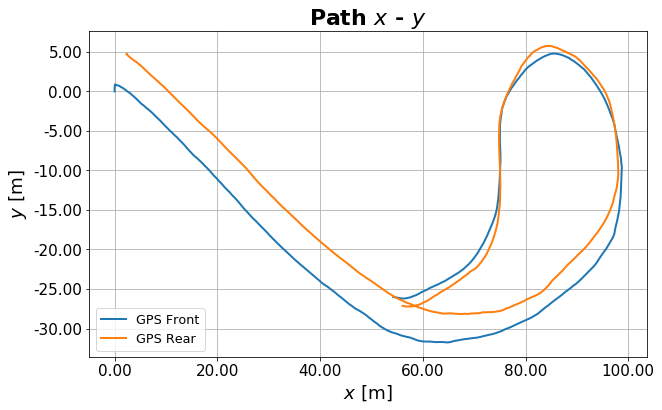

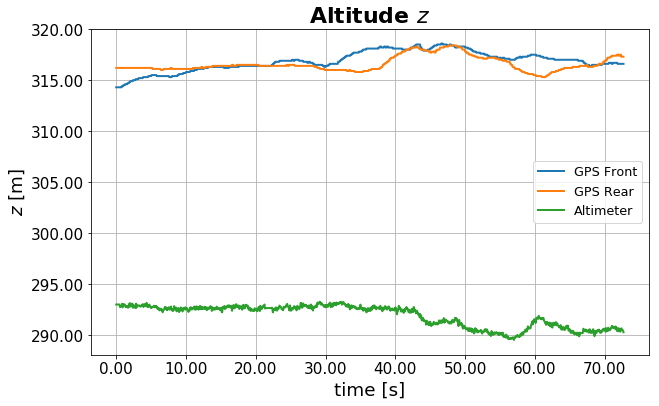

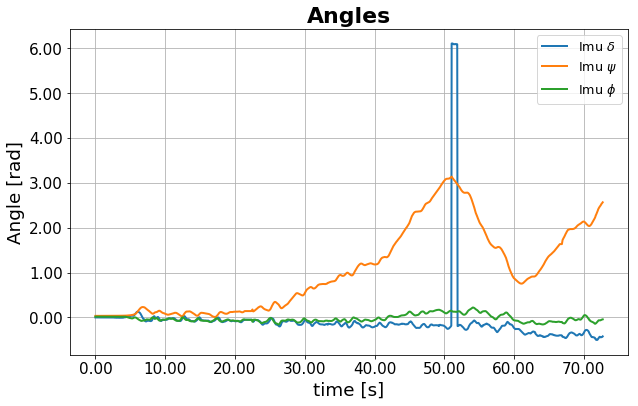

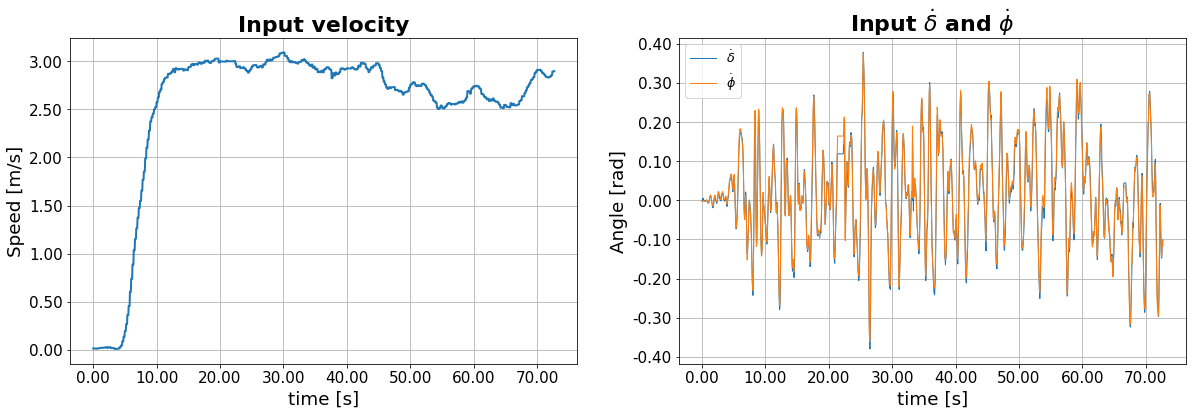

In [3]:
# Select which velocity to use: wheel encoder of GSP -based:

# [v, v_scale] = [di.real_v, 1.0]  # use Wheel encoder velocity, 0.23 scale for old datasets
[v, v_scale] = [di.real_v_gps, 1.0]  # use GPS velocity

# Use optical steering angle or IMU steering angle
use_optical_steering = False

sim = di.data.filter(items=[di.real_xf, di.real_xr, di.real_yf, di.real_yr,
                            di.real_zf, di.real_zr, di.real_za,
                            di.real_delta if use_optical_steering else di.real_delta_imu, 
                            di.real_psi, di.real_phi]).as_matrix()

sim_view = sim.copy()    

# Fix initial offset:
offset_x = sim[0, 0]
offset_y = sim[0, 2]
offset_delta = sim_view[0, 7]

sim_view[:, 0] -= offset_x
sim_view[:, 1] -= offset_x
sim_view[:, 2] -= offset_y 
sim_view[:, 3] -= offset_y
sim_view[:, 7] -= offset_delta

# select imputs:
U = di.data.filter(items=[v, di.angular_vel_delta, di.angular_vel_phi]).as_matrix()
U[:, 0] *= v_scale

# plot state variables
path_output_simulation =  'experiments/' + file_name.split("/")[0] + '/'
    
plot_real_data_state_variables(U=U, sim=sim_view, time=time, file_name=path_output_simulation, dpi=dpi)

In [4]:
class UKF_Sigma_model_sensor_fusion(object):
    def __init__(self, x_init, Q, R, sigma, dt=0.25, w=1.0):
        self.fx_filter_vel = 0.0
        self.fy_filter_vel = 0.0
        self.fz_filter_vel = 0.0
        self.fsigma_filter_vel = 0.0
        self.fpsi_filter_vel = 0.0
        self.fphi_filter_vel = 0.0
        self.U_init = []
                
        self.w = w
        self.dt = dt
        self.t = 0
        self.number_state_variables = 6
                         
        [self.alpha, self.beta, self.kappa] = [sigma[0], sigma[1], sigma[2]]
        
        self.points = MerweScaledSigmaPoints(n=self.number_state_variables, 
                                             alpha=self.alpha, beta=self.beta, kappa=self.kappa)

        self.kf = UKF(dim_x=number_state_variables, dim_z=10, dt=self.dt, 
                 fx=self.f_bicycle, hx=self.H_bicycle, points=self.points)
        
        # Q Process Noise Matrix
        self.kf.Q = Q 
       
        # R Measurement Noise Matrix
        self.kf.R = R

        self.kf.x = x_init    # Initial state
        self.kf.P = np.eye(self.number_state_variables) * 10     # Covariance matrix 

    def fx_filter(self, x, t):
        return self.fx_filter_vel

    def fy_filter(self, y, t):
        return self.fy_filter_vel
    
    def fz_filter(self, y, t):
        return self.fz_filter_vel
    
    def fsigma_filter(self, y, t):
        return self.fsigma_filter_vel

    def fpsi_filter(self, yaw, t):
        return self.fpsi_filter_vel
    
    def fphi_filter(self, yaw, t):
        return self.fphi_filter_vel
    
    def rk4(self, y, x, dx, f):
        k1 = dx * f(y, x)
        k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
        k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
        k4 = dx * f(y + k3, x + dx)

        return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

    def f_bicycle(self, x, dt, U=None):  
        if U is None:
            U = self.U_init
            
        x_out = x
        [x_ini, y_ini, z_ini, sigma_ini, psi_ini, phi_ini] = x
        
        v_ini = U[0]
        phi_dot = U[1]
        delta_dot = U[2]

        #Solve diff equation by approximation
        x = self.rk4(x_ini, self.t, self.dt, self.fx_filter)
        y = self.rk4(y_ini, self.t, self.dt, self.fy_filter)
        z = self.rk4(z_ini, self.t, self.dt, self.fz_filter)
        sigma = self.rk4(sigma_ini, self.t, self.dt, self.fsigma_filter)
        psi = self.rk4(psi_ini, self.t, self.dt, self.fpsi_filter)
        phi = self.rk4(phi_ini, self.t, self.dt, self.fphi_filter)

        self.fx_filter_vel = math.cos(psi) * v_ini
        self.fy_filter_vel = math.sin(psi) * v_ini
        self.fz_filter_vel = 0
        self.fsigma_filter_vel = (phi_dot / self.w)*(1 + (self.w**2)*(sigma_ini**2))
        self.fpsi_filter_vel = (v_ini * sigma_ini) / math.cos(phi_ini)
        self.fphi_filter_vel = phi_dot

        x_out[0] = x
        x_out[1] = y
        x_out[2] = z
        x_out[3] = sigma
        x_out[4] = psi
        x_out[5] = phi

        return x_out

    def H_bicycle(self, x):
        """ takes a state variable and returns the measurement
        that would correspond to that state. """        
        sensor_out = np.zeros(10)
        sensor_out[0] = x[0]
        sensor_out[1] = x[0]
        sensor_out[2] = x[1]
        sensor_out[3] = x[1]
        sensor_out[4] = x[2]
        sensor_out[5] = x[2]
        sensor_out[6] = x[2]
        sensor_out[7] = x[3] # sigma
        sensor_out[8] = x[4] # psi
        sensor_out[9] = x[5] # phi
        
        return sensor_out

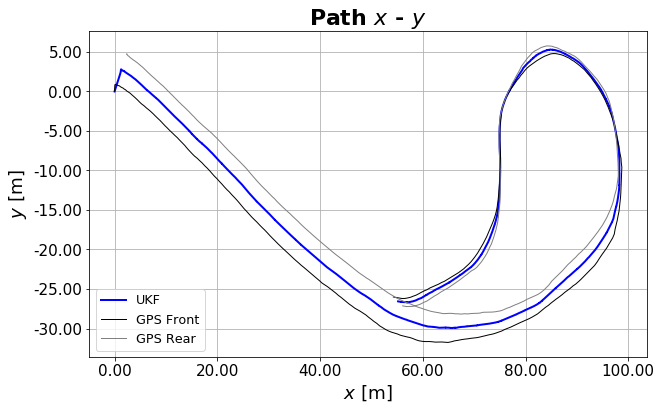

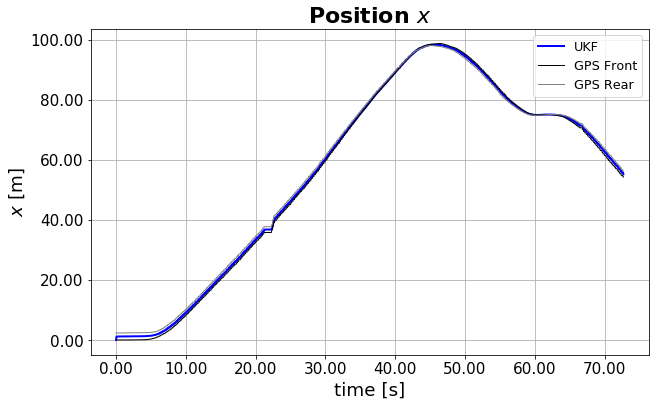

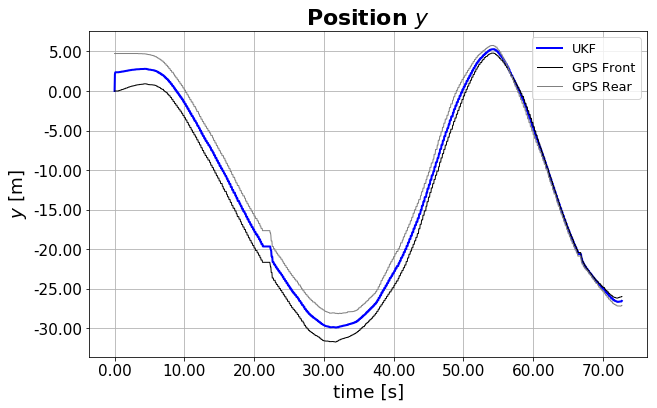

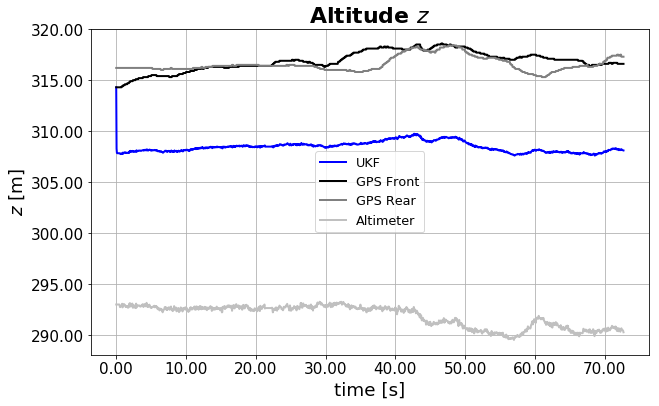

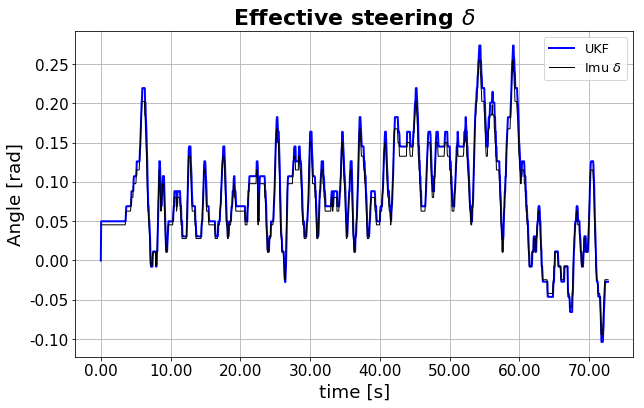

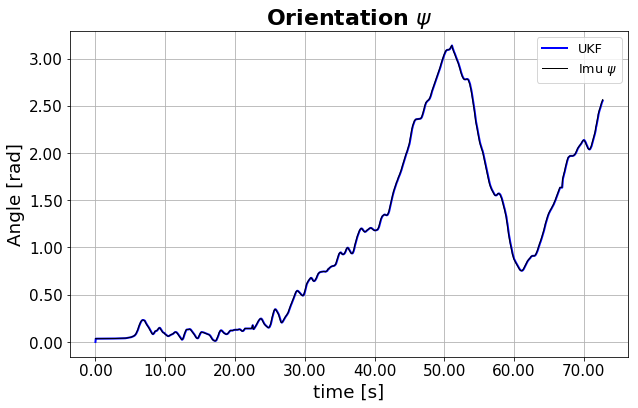

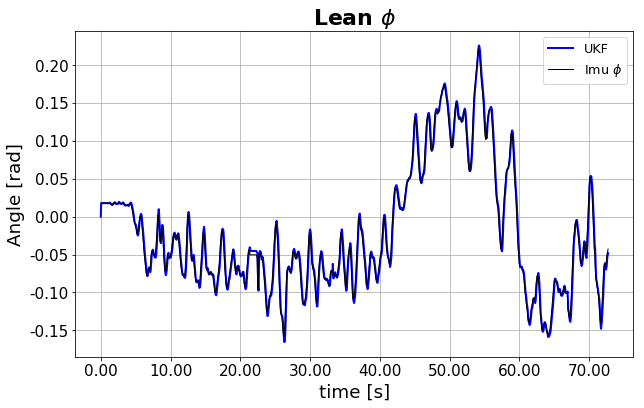

In [5]:
[t, wheel_distance, number_state_variables] = [0.0, 1.1, 6]

dt = 1.0/5.0 # Slower Sample Rate of the Measurements is 5Hz

zs_gt = []
zs_sim = di.data[[di.real_xf, di.real_xr, di.real_yf, di.real_yr, 
                  di.real_zf, di.real_zr, di.real_za,
                  di.real_delta, di.real_psi, di.real_phi]].as_matrix()

# use wheel velocity
#di.data[di.real_v] = di.data[di.real_v]*0.23 # Temporal adjustment - not necessay after update Arduino Micro
#u_sim = di.data[[di.real_v, di.angular_vel_phi, di.angular_vel_delta]].as_matrix()

# use GPS estimated velocity
u_sim = di.data[[di.real_v_gps, di.angular_vel_phi, di.angular_vel_delta]].as_matrix()
time_t = di.data[[di.time]].as_matrix()
z = zs_sim

# set UTM offset at first measurement
utm_offset_x = z[0, 0]
utm_offset_y = z[0, 2]
utm_offset_z = z[0, 4]

X_init = np.array([utm_offset_x, utm_offset_y, utm_offset_z, 0.0, 0.0, 0.0])  # [x, y, z, sigma, psi, phi]

# Q Process Noise Matrix
Q = np.diag([(4.5)**2, (4.5)**2, (3.5)**2, (0.8)**2, (0.4)**2, (1.2)**2])  # [x, y, z, sigma, psi, phi]

# measurement noise covariance R [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
# R_std = [8.5**2, 8.5**2, 8.5**2, 1.8**2, 8.5**2, 1.8**2] # [x, y, z, sigma, psi, phi]
R_std = [1.5**2, 1.5**2,  # x
         1.5**2, 1.5**2,  # y
         1.5**2, 1.5**2, 1.5**2,  # z
         0.05**2, 0.05**2, 0.5**2] # delta - psi - phi

# R Measurement Noise Matrix
R = np.diag(R_std)

''' Sigma point'''
sigma = [alpha, beta, kappa] = [0.7, 2.0, -2.0]

filter_ukf = UKF_Sigma_model_sensor_fusion(x_init=X_init, Q=Q, R=R, sigma=sigma, dt=dt, w=wheel_distance)

xs = np.zeros((len(time_t), number_state_variables))
mus = np.zeros((len(time_t), number_state_variables))
ps = np.zeros((len(time_t), number_state_variables, number_state_variables))
qs = np.zeros((len(time_t), number_state_variables, number_state_variables))

dt_real = dt

for i in range(len(time_t)):
    if i > 1:
        dt_real = float(time_t[i] - time_t[i-1])/1e9 # time: nano to seg
    
    xs[i,:]  = filter_ukf.kf.x

    filter_ukf.kf.predict(dt=dt_real, fx_args=(u_sim[i]))
    
    #Update measurements [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
    filter_ukf.kf.update(zs_sim[i])

# update delta based on sigma
xs[:, 3] = np.arctan2(xs[:, 3], 1/wheel_distance) # delta

# Fix initial offset (for visualization):
xs_view = xs.copy()
xs_view[:, 0] -= offset_x
xs_view[:, 1] -= offset_y

z_view = z.copy()
z_view[:, 0] -= offset_x 
z_view[:, 1] -= offset_x 
z_view[:, 2] -= offset_y
z_view[:, 3] -= offset_y 

path_output_filter = 'filters/UKF/experiments/' + file_name.split("/")[0] + "/"
plot_filter_results_real_data(xs=xs_view, sim=z_view, time=time, file_name=path_output_filter, filter_name="UKF",
                              dpi=150, format='png')

## Export to Google Earth

In [6]:
import utm
import datetime
from simplekml import Kml, Model, AltitudeMode, Orientation, Scale

# Get real time
time = di.data[[di.time]].as_matrix()

# Get gps_zone_number and  gps_zone_letter
gps_zone = di.data[[di.gps_zone_number, di.gps_zone_letter]].as_matrix()

car={}
car['when']=[]
car['filter']=[]
car['gps_front']=[]
car['gps_rear']=[]

for i in range(0, len(time)):
    (lat_filter, lon_filter) = utm.to_latlon(xs[i, 0], xs[i, 1], gps_zone[i, 0], gps_zone[i, 1])
    (lat_gps_front, lon_gps_front) = utm.to_latlon(z[i, 0], z[i, 2], gps_zone[i, 0], gps_zone[i, 1])
    (lat_gps_rear, lon_gps_rear) = utm.to_latlon(z[i, 1], z[i, 3], gps_zone[i, 0], gps_zone[i, 1])
    
    d = datetime.datetime.fromtimestamp(float(time[i])/1e9)
    car["when"].append(d.strftime("%Y-%m-%dT%H:%M:%SZ"))
    car["filter"].append((lon_filter, lat_filter , 0))
    car["gps_front"].append((lon_gps_front, lat_gps_front, 0))
    car["gps_rear"].append((lon_gps_rear, lat_gps_rear, 0))

# Create the KML document
kml = Kml(name=d.strftime("%Y-%m-%d %H:%M"), open=1)

# Create the track
trk = kml.newgxtrack(name="UKF", altitudemode=AltitudeMode.clamptoground,
                     description="State Estimation from UKF")

gps_front = kml.newgxtrack(name="GPS FRONT", altitudemode=AltitudeMode.clamptoground,
                     description="Raw data from GPS FRONT (input to filter)")

gps_rear = kml.newgxtrack(name="GPS REAR", altitudemode=AltitudeMode.clamptoground,
                     description="Raw data from GPS REAR (input to filter)")

# Add all the information to the track
trk.newwhen(car["when"])
trk.newgxcoord(car["filter"])

gps_front.newwhen(car["when"][::5])
gps_front.newgxcoord((car["gps_front"][::5]))

gps_rear.newwhen(car["when"][::5])
gps_rear.newgxcoord((car["gps_rear"][::5]))

# Style of the Track
trk.iconstyle.icon.href = "http://maps.google.com/mapfiles/kml/paddle/red-circle.png"
trk.labelstyle.scale = 1
trk.linestyle.width = 4
trk.linestyle.opacity = 1
trk.linestyle.color = '64F01414' # aabbggrr

gps_front.iconstyle.icon.href = ""
gps_front.labelstyle.scale = 0
gps_front.linestyle.width = 4
gps_front.linestyle.opacity = 1
gps_front.linestyle.color = '6414B400'

gps_rear.iconstyle.icon.href = ""
gps_rear.labelstyle.scale = 0
gps_rear.linestyle.width = 4
gps_rear.linestyle.opacity = 1
gps_rear.linestyle.color = '6414F00A'

# Saving
name_output_kmz = path_output_filter + "UKF_google_earth.kmz"
kml.savekmz(name_output_kmz)

print("Google Earth file saved into: " + name_output_kmz)

Google Earth file saved into: filters/UKF/experiments/field_half/UKF_google_earth.kmz
